
# Examen: Clasificador de texto con Redes Neuronales — 20 Newsgroups
Marcos Dayan Mann

A01782876


## Instalación de dependencias

In [1]:
import sys
!{sys.executable} -m pip install -q tensorflow scikit-learn scikeras plotly nltk pandas numpy matplotlib seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.4.1/libexec/bin/python -m pip install --upgrade pip


## 1) Preprocesamiento del texto

In [2]:
import json
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer


raw_train = fetch_20newsgroups(subset='train', remove=(), shuffle=True, random_state=42)
raw_test  = fetch_20newsgroups(subset='test',  remove=(), shuffle=True, random_state=42)


df_train = pd.DataFrame({
    'text': raw_train.data,
    'label': [raw_train.target_names[t] for t in raw_train.target],
})
df_test = pd.DataFrame({
    'text': raw_test.data,
    'label': [raw_test.target_names[t] for t in raw_test.target],
})

# label encoding
le = LabelEncoder()
df_train['y'] = le.fit_transform(df_train['label'])
df_test['y']  = le.transform(df_test['label'])


X_train, X_val, y_train, y_val = train_test_split(
    df_train['text'].values,
    df_train['y'].values,
    test_size=0.15,
    random_state=42,
    stratify=df_train['y'].values
)

# guardo el mapeo de las clases en un archivo json
ROOT_DIR = Path('')
label_map = {i: c for i, c in enumerate(le.classes_)}
(ROOT_DIR / 'label_map.json').write_text(json.dumps(label_map, indent=2), encoding='utf-8')

#  vectorización TF-IDF
tfidf = TfidfVectorizer(
    max_features=30000,
    ngram_range=(1, 2),
    stop_words='english',
    min_df=3
)
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf   = tfidf.transform(X_val)
X_test_tfidf  = tfidf.transform(df_test['text'].values)


X_train_tfidf.shape, X_val_tfidf.shape, X_test_tfidf.shape, len(label_map)


((9616, 30000), (1698, 30000), (7532, 30000), 20)

## 2) Visualización de la distribución de datos (histogramas y boxplots)

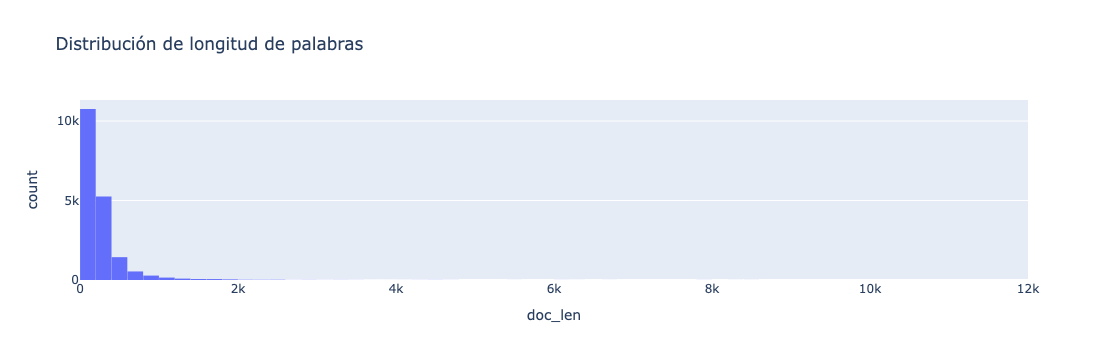

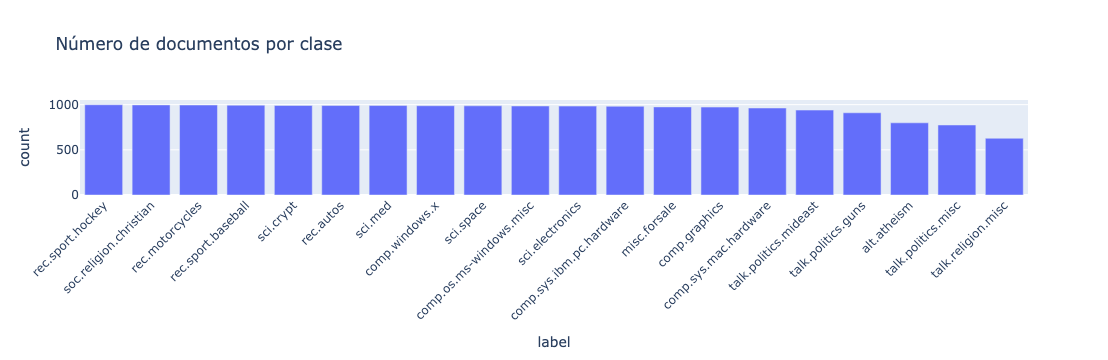

/var/folders/p9/600y_zfn6z7d0zb79fyqhf9c0000gn/T/ipykernel_92155/924562071.py:35: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



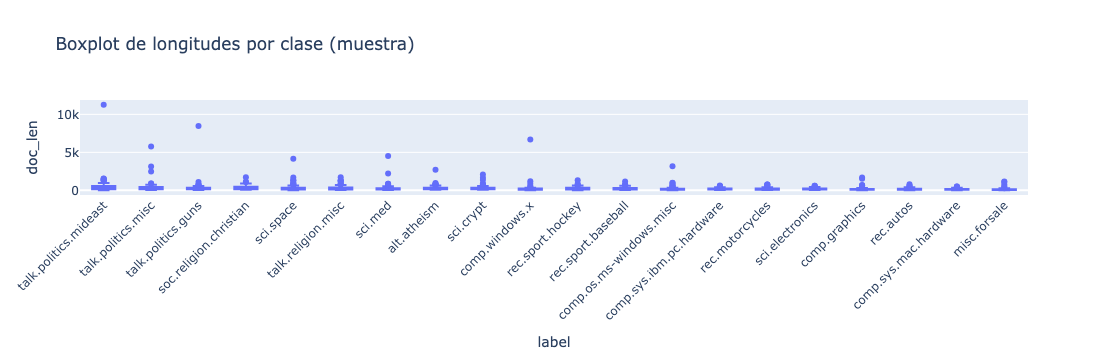

In [4]:
import plotly.express as px
import pandas as pd

# Unir train y test en un solo df para graficar
df = pd.concat(
    [
        df_train.assign(split='train')[['text','label','y','split']],
        df_test.assign(split='test')[['text','label','y','split']],
    ],
    ignore_index=True
)

# Longitud de palabrs usando el texto crudo
df['doc_len'] = df['text'].astype(str).str.split().str.len()

# Histograma de longitudes
fig1 = px.histogram(df, x='doc_len', nbins=100,
                    title='Distribución de longitud de palabras')
fig1.update_layout(bargap=0.01)
fig1.show()

# Conteo por clase
df_counts = (df.groupby('label')
               .size()
               .reset_index(name='count')
               .sort_values('count', ascending=False))

fig2 = px.bar(df_counts, x='label', y='count',
              title='Número de documentos por clase')
fig2.update_layout(xaxis={'categoryorder':'total descending', 'tickangle':-45})
fig2.show()

# Boxplot por clase 
sample_for_box = (df.groupby('label', group_keys=False)
                    .apply(lambda x: x.sample(min(80, len(x)), random_state=21))
                    .reset_index(drop=True))

fig3 = px.box(sample_for_box, x='label', y='doc_len',
              title='Boxplot de longitudes por clase (muestra)')
fig3.update_layout(xaxis={'categoryorder':'total descending', 'tickangle':-45})
fig3.show()


## 3) Red neuronal densa en Keras

In [10]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

num_classes = len(label_map)

def build_mlp(
    input_dim,
    n_classes,
    hidden_units=256,
    dropout=0.5,
    lr=1e-3
):
    inputs = keras.Input(shape=(input_dim,))
    x = layers.Dense(hidden_units, activation='relu')(inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(hidden_units // 2, activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

base_model = build_mlp(X_train_tfidf.shape[1], n_classes=len(label_map), hidden_units=256, dropout=0.4, lr=1e-3)
base_model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 30000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 256)            │     7,680,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,715,732 (29.43 MB)

 Trainable params: 7,715,732 (29.43 MB)

 Non-trainable params: 0 (0.00 B)

Como se puede ver, creamos un modelo de 7,715,732 parámetros y de 2 capas.

Para optimizar el modelo y qe no tenga overfitting, agregué unas capas de dropout, que lo que hacen es que en cada paso del etrenamiento se apaga cierta cantidad de neuronas para regularizar los pesos entre las épocas y evitar el overfitting

## 4) Entrenamiento + ajuste de hiperparámetros

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

keras_clf = KerasClassifier(
    model=build_mlp,
    # Pasamos explícitamente las dimensiones que build_mlp espera:
    model__input_dim=X_train_tfidf.shape[1],
    model__n_classes=len(label_map),
    verbose=0
)

param_grid = {
    "model__hidden_units": [256, 384],
    "model__dropout": [0.3, 0.5],
    "model__lr": [1e-3, 5e-4],
    "epochs": [4],   # para tener los resultrados más óptimos es mejor tener un mayor número de épocas, pero por cuestiones del tiempo del examen lo mantengo con este número
    "batch_size": [64, 128]
}

grid = GridSearchCV(
    estimator=keras_clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=1, 
    refit=True,
    error_score='raise' 
)

grid.fit(X_train_tfidf, y_train)

print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor exactitud (cv):", grid.best_score_)

best_model = grid.best_estimator_.model_


Mejores hiperparámetros: {'batch_size': 64, 'epochs': 4, 'model__dropout': 0.5, 'model__hidden_units': 384, 'model__lr': 0.001}
Mejor exactitud (cv): 0.9029735263022497


## 5) Curvas de aprendizaje

Epoch 1/6
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.5358 - loss: 1.9126 - val_accuracy: 0.8710 - val_loss: 0.6066
Epoch 2/6
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9131 - loss: 0.3711 - val_accuracy: 0.9075 - val_loss: 0.3490
Epoch 3/6
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9740 - loss: 0.1220 - val_accuracy: 0.9164 - val_loss: 0.3122
Epoch 4/6
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9896 - loss: 0.0551 - val_accuracy: 0.9170 - val_loss: 0.3140
Epoch 5/6
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9959 - loss: 0.0289 - val_accuracy: 0.9152 - val_loss: 0.3223
Epoch 6/6
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9959 - loss: 0.0230 - val_accuracy: 0.9128 - val_loss: 0.3298


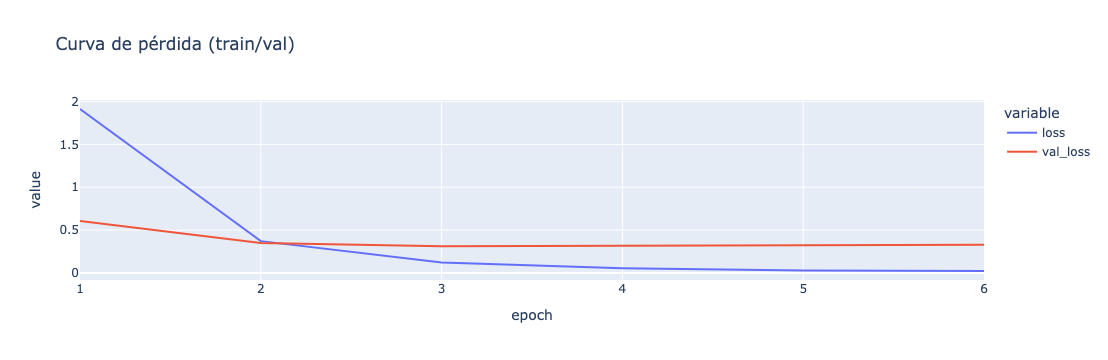

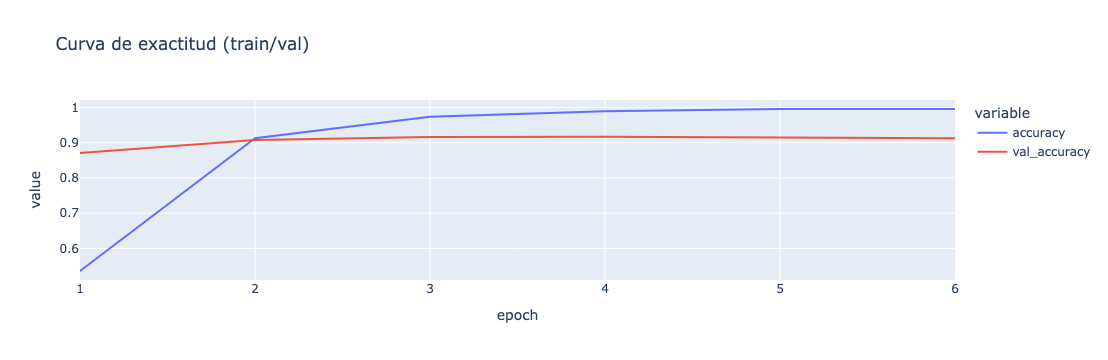

In [12]:
from scikeras.wrappers import KerasClassifier
import pandas as pd
import numpy as np
import plotly.express as px

# los mejores hiperparámetros con nombres correctos
best_params = grid.best_params_

best_hidden = best_params.get('model__hidden_units', 256)
best_drop   = best_params.get('model__dropout', 0.5)
best_lr     = best_params.get('model__lr', 1e-3)
best_epochs = max(6, best_params.get('epochs', 6))
best_bs     = best_params.get('batch_size', 64)

# crea un nuevo clasifiador con los mejores parámetros
retrainer = KerasClassifier(
    model=build_mlp,
    model__input_dim=X_train_tfidf.shape[1], # éstos parámetros con model__ de prefijo, son parámetros que nuestro modelo espera recibir
    model__n_classes=len(label_map),
    model__hidden_units=best_hidden,
    model__dropout=best_drop,
    model__lr=best_lr,
    epochs=best_epochs,
    batch_size=best_bs,
    verbose=1
)


retrainer.fit(X_train_tfidf, y_train, validation_data=(X_val_tfidf, y_val))

hist_dict = retrainer.history_  
hist_df = pd.DataFrame(dict(hist_dict))     # convertir a DataFrame para visualizar
hist_df['epoch'] = np.arange(1, len(hist_df) + 1)

# 5) Graficar curvas
fig_loss = px.line(hist_df, x='epoch', y=['loss','val_loss'], title='Curva de pérdida (train/val)')
fig_loss.show()

fig_acc  = px.line(hist_df, x='epoch', y=['accuracy','val_accuracy'], title='Curva de exactitud (train/val)')
fig_acc.show()


## 6) Métricas de desempeño

In [15]:
from sklearn.metrics import accuracy_score, classification_report

y_val_pred = retrainer.predict(X_val_tfidf)

print("Accuracy (val):", accuracy_score(y_val, y_val_pred))

num_classes = len(label_map)
print(classification_report(y_val, y_val_pred,
                            target_names=[label_map[i] for i in range(num_classes)]))


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Accuracy (val): 0.9128386336866903
                          precision    recall  f1-score   support

             alt.atheism       0.96      0.93      0.94        72
           comp.graphics       0.76      0.84      0.80        88
 comp.os.ms-windows.misc       0.81      0.91      0.86        89
comp.sys.ibm.pc.hardware       0.84      0.81      0.82        88
   comp.sys.mac.hardware       0.92      0.90      0.91        87
          comp.windows.x       0.91      0.88      0.89        89
            misc.forsale       0.83      0.82      0.82        88
               rec.autos       0.95      0.88      0.91        89
         rec.motorcycles       0.97      0.92      0.94        90
      rec.sport.baseball       0.94      0.93      0.94        89
        rec.sport.hockey       0.90      0.94      0.92        90
               sci.crypt       0.98      0.96      0.97        89
         sci.electronics       0.84      0.89      0.86        89
 

## 7) Matriz de confusión

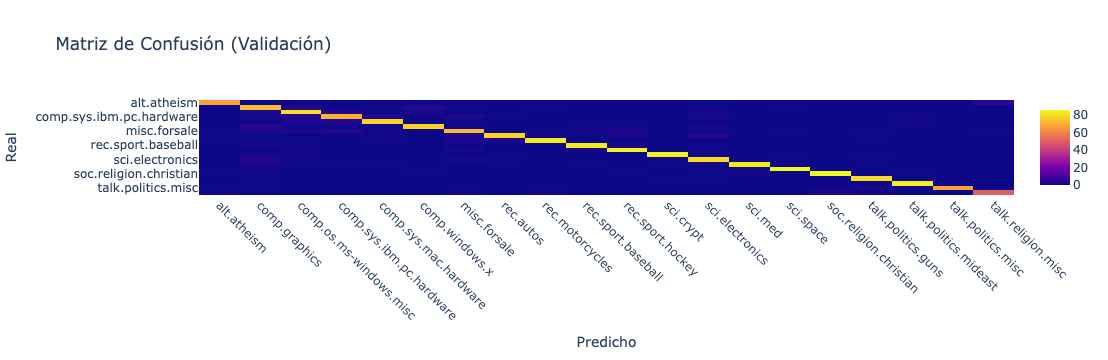

In [16]:

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_val_pred, labels=list(range(num_classes)))
cm_df = pd.DataFrame(cm, index=[label_map[i] for i in range(num_classes)],
                        columns=[label_map[i] for i in range(num_classes)])

fig_cm = px.imshow(cm_df, title='Matriz de Confusión (Validación)', aspect='auto')
fig_cm.update_xaxes(title_text='Predicho', tickangle=45)
fig_cm.update_yaxes(title_text='Real')
fig_cm.show()


## 8) Experimentos con diferentes arquitecturas de redes

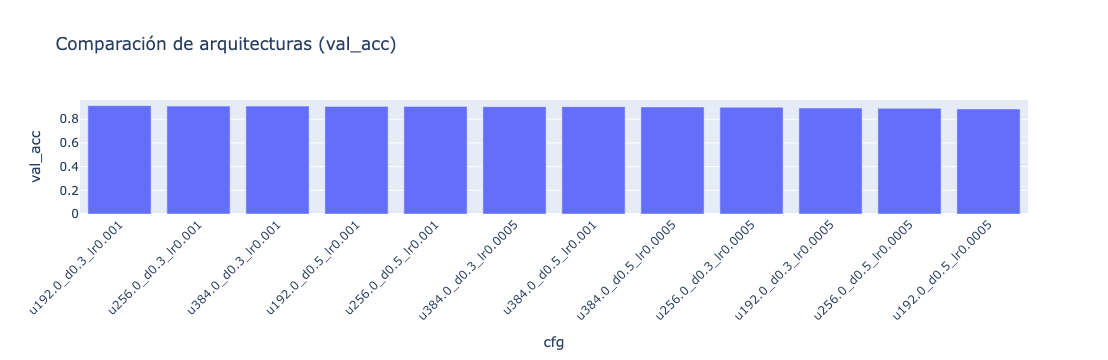

,units,drop,lr,epochs,val_acc,cfg
0,192,0.3,0.0010,3,0.914016,u192.0_d0.3_lr0.001
1,256,0.3,0.0010,3,0.910483,u256.0_d0.3_lr0.001
2,384,0.3,0.0010,3,0.910483,u384.0_d0.3_lr0.001
3,192,0.5,0.0010,3,0.908127,u192.0_d0.5_lr0.001
4,256,0.5,0.0010,3,0.908127,u256.0_d0.5_lr0.001
5,384,0.3,0.0005,3,0.905771,u384.0_d0.3_lr0.0005
6,384,0.5,0.0010,3,0.905771,u384.0_d0.5_lr0.001
7,384,0.5,0.0005,3,0.903416,u384.0_d0.5_lr0.0005
8,256,0.3,0.0005,3,0.901060,u256.0_d0.3_lr0.0005
9,192,0.3,0.0005,3,0.893993,u192.0_d0.3_lr0.0005


In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn.metrics import accuracy_score
import pandas as pd
import plotly.express as px


NUM_CLASSES = len(label_map)


# ésta función va a entrenar  evaluar una NN con diferente cantidad de neuronas iniciales y de dropout
def train_and_eval(units, drop, lr, epochs=4):
    np.random.seed(42)
    tf.random.set_seed(42)
    K.clear_session()

    m = build_mlp(
        input_dim=X_train_tfidf.shape[1],
        n_classes=NUM_CLASSES,
        hidden_units=units,
        dropout=drop,
        lr=lr
    )
    _ = m.fit(
        X_train_tfidf, y_train,
        validation_data=(X_val_tfidf, y_val),
        epochs=epochs,
        batch_size=128,
        verbose=0
    )
    y_pred = m.predict(X_val_tfidf, batch_size=1024, verbose=0).argmax(axis=1)
    acc = accuracy_score(y_val, y_pred)
    return {'units': units, 'drop': drop, 'lr': lr, 'epochs': epochs, 'val_acc': acc}


experiments = []
for units in [192, 256, 384]: # probar difernetes unidades para revisar el performance en cada uno de los casos
    for drop in [0.3, 0.5]:
        for lr in [1e-3, 5e-4]:
            experiments.append(train_and_eval(units, drop, lr, epochs=3))

exp_df = pd.DataFrame(experiments).sort_values('val_acc', ascending=False).reset_index(drop=True)
exp_df['cfg'] = exp_df.apply(lambda r: f"u{r['units']}_d{r['drop']}_lr{r['lr']}", axis=1)

fig_exp = px.bar(
    exp_df,
    x='cfg', y='val_acc',
    hover_data=['units','drop','lr','epochs'],
    title='Comparación de arquitecturas (val_acc)'
)
fig_exp.update_layout(xaxis_tickangle=-45)
fig_exp.show()

exp_df.head(10)


## 9) Validación cruzada k-fold (StratifiedKFold)

In [20]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from scikeras.wrappers import KerasClassifier

# usar los mejores parámetros para el k-fold
best_hidden = best_params.get('model__hidden_units', 256)
best_drop   = best_params.get('model__dropout', 0.5)
best_lr     = best_params.get('model__lr', 1e-3)

kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

clf_for_cv = KerasClassifier(
    model=build_mlp,
    model__input_dim=X_train_tfidf.shape[1],
    model__n_classes=len(label_map),
    model__hidden_units=best_hidden,
    model__dropout=best_drop,
    model__lr=best_lr,
    epochs=4,
    batch_size=128,
    verbose=0
)

cv_scores = cross_val_score(clf_for_cv, X_train_tfidf, y_train,
                            cv=kf, scoring='accuracy', n_jobs=1)

print("Accuracies (CV):", cv_scores)
print("CV mean:", cv_scores.mean(), "±", cv_scores.std())


Accuracies (CV): [0.90361822 0.89921997 0.90265211]
CV mean: 0.9018300969094285 ± 0.0018873117713130573


## 10) Curva ROC y AUC (clasificación binaria)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


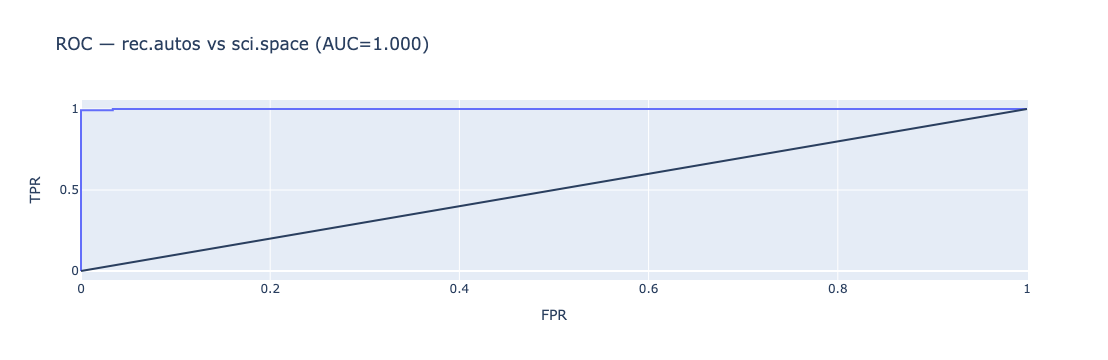

AUC: 0.9997175340724526


In [21]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import plotly.express as px

# Seleccionar dos clases para comparar en el roc
cls_a, cls_b = 'rec.autos', 'sci.space'


mask_bin = df_train['label'].isin([cls_a, cls_b])
texts_bin = df_train.loc[mask_bin, 'text'].values
labels_bin = df_train.loc[mask_bin, 'label'].values


X_train_bin, X_val_bin, y_train_bin, y_val_bin = train_test_split(
    texts_bin,
    labels_bin,
    test_size=0.2,
    random_state=42,
    stratify=labels_bin
)


tfidf_bin = TfidfVectorizer(max_features=30000, ngram_range=(1,2), stop_words='english', min_df=3)
X_train_bin = tfidf_bin.fit_transform(X_train_bin)
X_val_bin   = tfidf_bin.transform(X_val_bin)


le_bin = LabelEncoder()
y_train_bin_enc = le_bin.fit_transform(y_train_bin)
y_val_bin_enc   = le_bin.transform(y_val_bin)

# Entrenar red binaria
bin_model = build_mlp(
    input_dim=X_train_bin.shape[1],
    n_classes=2,
    hidden_units=256,
    dropout=0.4,
    lr=1e-3
)
bin_model.fit(
    X_train_bin, y_train_bin_enc,
    epochs=5,
    batch_size=128,
    verbose=0,
    validation_data=(X_val_bin, y_val_bin_enc)
)


y_val_proba = bin_model.predict(X_val_bin)[:, 1]


fpr, tpr, thr = roc_curve(y_val_bin_enc, y_val_proba)
roc_auc = auc(fpr, tpr)

roc_df = pd.DataFrame({'FPR': fpr, 'TPR': tpr})
fig_roc = px.line(roc_df, x='FPR', y='TPR',
                  title=f'ROC — {cls_a} vs {cls_b} (AUC={roc_auc:.3f})')
fig_roc.add_shape(type='line', x0=0, y0=0, x1=1, y1=1)
fig_roc.show()

print("AUC:", roc_auc)



## 11) Hallazgos y conclusiones

Es la primera vez que implementamos una NN con liberías como Keras y tensorflow. No tenía mucho conocimiento y tuve que investigar y revisar el uso de las libererías, pero me sorprendió lo útiles que son, y lo eficientes y configurables, tan así, que facilitan en gran manera el trabajo. Tienen ajustes para muchos parámetros, ajustar capas, regularizar, entre otras configuraciones, lo cual me gustó mucho.

Aprendí que en sí no hay una metodología correcta para el diseño de NN, hay patrones e hiperparámetros que han funcionado mejor que otros, pero no hay una forma de saber qué arquitectura será la mejor para cada tipo de problema.

Por eso es que es muy importante hacer pruebas con diferentes arquitecturas, hiperparámetros, hacer cross validations como la k-fold, para poder encontrar aunque sea un máximo local en cuestriones de eficiencia y las métricas del modelo como accuracy, precision, recall y F1.

En cuanto al modelo, quedé impresionado con las métricas que logró, una accuracy con cross validation de 90% para categorizar en 20 tipos de textos, además de un área debajo de la curva de 99.9% en la métrica ROC entre las categorías rec.autos y sci.space.

Sin duda, las redes neuronales son una excelente herramienta para resolver problemas comlejos de clasificación, en donde cada uno de los vectores de entrada tenga una gran imensionalidad, y se requiera de miles o millones, incluso billones de parámetros para poder crear un modelo de mayor capacidad.

Por último, es muy útil ayudarnos de métricas y gráficas comunes en ML como la matriz de confuxión, la ROC que se puede graficar, ésto para revisar además de numéricamente, sino también gráficamente el resultado de nuestros algoritmos de ML creados. Entre más compleja la arquotectura de los modelos y mayor el nivel de parámetros, más difícil es visualizar el error y optimizar los modelos, por lo que es muy importante ayudarnos de todas las herramientas posibles para poder entender en dónde está el modelo y poder tomar desiciones para mejorar sus métricas de evaluación.
